<a href="https://colab.research.google.com/github/AMMISAIDFaical/Train-pretrained-VisionTransformersBasedModels-HugginFace-on-Manually-Annotated-Wheat/blob/main/OnnxSegformer_20_Epochs_Wheat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -q segmentation_models_pytorch
import os
from tqdm import tqdm
import numpy as np

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler,RandomSampler,random_split
from torch.cuda import amp
from PIL import Image
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms

!pip install transformers
#getting transformers from huggingface "transformers" library
from transformers import (SegformerForSemanticSegmentation,SegformerImageProcessor)

class config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LEARNING_RATE = 1e-3
    N_EPOCHS = 20
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-5
    T_max         = 20
    T_0           = 5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Retrive data from roboflow

In [ ]:
!pip install roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="2vJwGTWFkN6th0Sx41S7")
project = rf.workspace("masters-1u0oz").project("sam-semantic-segmentation")
dataset = project.version(6).download("png-mask-semantic")

### dataset definition

In [ ]:
class WheatCustomDataset():
    def __init__(self, root_dir,img_proc, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = []
        self.mask_files = []
        self.image_processor = img_proc

        img_dir = os.path.join(root_dir)
        mask_dir = img_dir
        img_files = os.listdir(img_dir)

        for f in img_files:
            if f not in ("_classes.csv"):
                if f.endswith(".jpg"):
                    img_path = os.path.join(root_dir, f)
                    self.img_files.append(img_path)
                    png_path = os.path.join(root_dir, f)
                    self.mask_files.append(png_path.replace('.jpg','_mask.png'))

    def __getitem__(self, idx):
        label = None
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]
        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if "loh" in img_path:
            label = "Healthy"
        elif "los" in img_path:
            label = "Septoria"
        elif "lolr" in img_path:
            label = "StripeRust"
        else:
            label = "Unknown"

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, mask, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs,label


    def __len__(self):
        return len(self.img_files)

### get data loaders from preprocessed dataset

In [ ]:
# processor = BeitImageProcessor()
processor = SegformerImageProcessor(size = 256)

def get_loaders():
    train_dataset = WheatCustomDataset("/content/Sam-Semantic-segmentation--6/train",processor)
    valid_dataset = WheatCustomDataset("/content/Sam-Semantic-segmentation--6/valid",processor)
    test_dataset = WheatCustomDataset("/content/Sam-Semantic-segmentation--6/test",processor)

    # # Create dataloaders for the training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=16,pin_memory=True,num_workers=2,shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32,pin_memory=True,num_workers=2,shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=2,shuffle=True)

    return train_loader, valid_loader, test_loader, train_dataset

train_loader, valid_loader, test_loader, train_dataset = get_loaders()


### plot some samples from dataset

### get beit model and setting numbers of labels to three rust septoria healthy

In [ ]:
pretrained_model_name = "nvidia/mit-b5"
model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model_name,num_labels = 4)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_fuse.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.num_batches_tracked']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### methode to upscale model output back to the image original resolutions

In [ ]:
# 224
def upscale_logits(logit_outputs, res=256):
    return nn.functional.interpolate(
      logit_outputs,
      size=(res,res),
      mode='bilinear',
      align_corners=False
    )

### metrics

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn.functional as F

def metrics(probs,yb):
    yb = yb.long()
    probs = torch.argmax(probs, dim=1)  # convert with argmax to shape of target
    tp, fp, fn, tn = smp.metrics.get_stats(probs, yb, mode='multiclass',num_classes =3)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
    f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
    return iou_score,f1_score,f2_score,accuracy,recall

### early stopping

In [ ]:
import io
import copy

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
            if self.restore_best_weights:
                model.load_state_dict(self.best_model.state_dict())
            return True
        self.status = f"{self.counter}/{self.patience}"
        return False


def fetch_scheduler(optimizer):
    if config.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=config.T_max, eta_min=config.min_lr)

    elif config.scheduler == None:
        return None

    return scheduler

### engine class

In [ ]:
es = EarlyStopping()
scaler = amp.GradScaler()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = fetch_scheduler(optimizer)

model.to(config.DEVICE)

class engine():
    def train_batch(model, data, optimizer):
        model.train()
        batch, classs = data
        pixel_values = batch["pixel_values"].to(config.DEVICE)
        labels = batch["labels"].to(config.DEVICE)

        with amp.autocast(enabled=True):
            # forward + backward + optimize
            outputs = model(pixel_values=pixel_values, labels=labels)
            optimizer.zero_grad()
            train_loss, logits = outputs.loss, outputs.logits


        scaler.scale(train_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None:
            scheduler.step()

        return train_loss


    @torch.no_grad()
    def validate_batch(model, data):
        model.eval()

        batch, classs = data
        pixel_values = batch["pixel_values"].to(config.DEVICE)
        labels = batch["labels"].to(config.DEVICE)

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        valid_loss, logits = outputs.loss, outputs.logits

        # Upscale the logit tensor and get the probabilities with the softmax
        probs = upscale_logits(logits)

        if es(model,valid_loss.item()): done = True

        iou_score,f1_score,f2_score,accuracy,recall = metrics(probs,labels)

        return valid_loss,iou_score,f1_score,f2_score,accuracy,recall

def run():
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    iou_scores = []
    f1_scores = []
    f2_scores = []
    accuracies = []
    recalls = []

    for epoch in range(3):
        print("####################")
        print(f"       Epoch: {epoch}   ")
        print("####################")

        for bx, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            train_loss = engine.train_batch(model, data, optimizer)
            train_losses.append(train_loss)

        for bx, data in tqdm(enumerate(valid_loader), total = len(valid_loader)):
            valid_loss,iou_score,f1_score,f2_score,accuracy,recall = engine.validate_batch(model, data)
            iou_scores.append(iou_score)
            f1_scores.append(f1_score)
            f2_scores.append(f2_score)
            valid_losses.append(valid_loss)
            valid_accuracies.append(accuracy)
            recalls.append(recall)

        print('Epoch : ', epoch,
              'Train Loss : ', train_loss,
              'Validation Loss : ', valid_loss,
              'Valid Accuracy : ', accuracy,
              'IoU Score : ',iou_score,
              'F1 Score : ',f1_score,
              'F2 Score : ',f2_score,
              'Recall : ',recall
             )
    return  train_losses ,valid_losses ,valid_accuracies ,iou_scores ,f1_scores ,f2_scores ,accuracies ,recalls

### lunch train

In [ ]:
train_losses ,valid_losses ,valid_accuracies ,iou_scores ,f1_scores ,f2_scores ,accuracies ,recalls = run()

### Get plots transform_list_values to move them to cpu so they can be plotted

In [ ]:
from scipy.ndimage import gaussian_filter1d

epochs = np.arange(1, 20)  # Generate an array from 1 to 30

def plot_results(epochs, values, label, xlabel, ylabel, title, point_min_max=True, sigma=2):
    plt.figure()
    smoothed_values = gaussian_filter1d(values[:len(epochs)], sigma=sigma)  # Apply Gaussian smoothing to values
    plt.plot(epochs, smoothed_values, label=label)  # Plot smoothed values
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.5)

    if point_min_max:
        min_index = np.argmin(smoothed_values)  # Calculate the minimum index based on smoothed values
        min_value = smoothed_values[min_index]
        plt.scatter(epochs[min_index], min_value, color='red', label=f'Min: {min_value:.4f}')
        plt.annotate(f'Min: {min_value:.4f}', xy=(epochs[min_index], min_value), xytext=(epochs[min_index] + 1, min_value),
                     arrowprops=dict(arrowstyle='->', color='red'))

        max_index = np.argmax(smoothed_values)  # Calculate the maximum index based on smoothed values
        max_value = smoothed_values[max_index]
        plt.scatter(epochs[max_index], max_value, color='green', label=f'Max: {max_value:.4f}')
        plt.annotate(f'Max: {max_value:.4f}', xy=(epochs[max_index], max_value), xytext=(epochs[max_index] - 1, max_value),
                     arrowprops=dict(arrowstyle='->', color='green'))

    # Add legend with immersive background
    legend = plt.legend()
    legend.get_frame().set_alpha(0.5)

    plt.show()

def transform_list_values(lst):
    transformed_lst = [np.asarray(acc.cpu().detach().numpy()) for acc in lst]
    return transformed_lst

# preparing losses lists and plotting them

In [ ]:
train_losses = transform_list_values(train_losses)
valid_losses = transform_list_values(valid_losses)

# Plot train loss
plot_results(epochs, train_losses, 'Train Loss', 'Epoch', 'Loss', 'Train Loss')

# # Plot validation loss
plot_results(epochs, valid_losses, 'Validation Loss', 'Epoch', 'Loss', 'Validation Loss')

## preparing metrics lists and plotting them

In [ ]:
valid_accuracies = transform_list_values(valid_accuracies)
iou_scores = transform_list_values(iou_scores)
f1_scores = transform_list_values(f1_scores)
f2_scores = transform_list_values(f2_scores)
recalls = transform_list_values(recalls)
accuracies = transform_list_values(accuracies)

# Plot valid accuracy
plot_results(epochs, valid_accuracies, 'Valid Accuracy', 'Epoch', 'Accuracy', 'Validation Accuracy')

# Plot IoU score
plot_results(epochs, iou_scores, 'IoU Score', 'Epoch', 'Score', 'IoU Score')

# Plot F1 score
plot_results(epochs, f1_scores, 'F1 Score', 'Epoch', 'Score', 'F1 Score')

# Plot F2 score
plot_results(epochs, f2_scores, 'F2 Score', 'Epoch', 'Score', 'F2 Score')

# Plot Recalls
plot_results(epochs, recalls, 'Recall', 'Epoch', 'Score', 'Recall')

# Saving model Wieghts

In [ ]:
import copy

def save_model_pth():
    last_model_wts = copy.deepcopy(model.state_dict())
    PATH = f"/content/drive/MyDrive/Plant diseases SS Models weights/vit based /Wheat_fINAL_Segformer_20_Epochs.pth"
    torch.save(model.state_dict(), PATH)
# save_model_pth()

def load_model(path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

segformer_model = load_model("/content/drive/MyDrive/Plant diseases SS Models weights/vit based /Wheat_fINAL_Segformer_20_Epochs.pth")

### Loading test samples getting predictions

In [ ]:
def get_predictions(test_loader, model):
  # Assuming you have the batch dictionary with 'pixel_values', 'labels', and 'masks'
  batch, labels = next(iter(test_loader))
  # Accessing the image, mask, and label from the batch
  xb = batch['pixel_values']
  yb = batch['labels']
  labels = labels
  model.to(config.DEVICE)
  model.eval()
  # # forward pass
  outputs = model(pixel_values=xb.to(config.DEVICE))
  # # logits are of shape (batch_size, num_labels, height/4, width/4)
  logits = outputs.logits.cpu()
  #up scalling logits
  upscaled = upscale_logits(logits)
  return xb, yb, upscaled,labels

 # plot results methodes

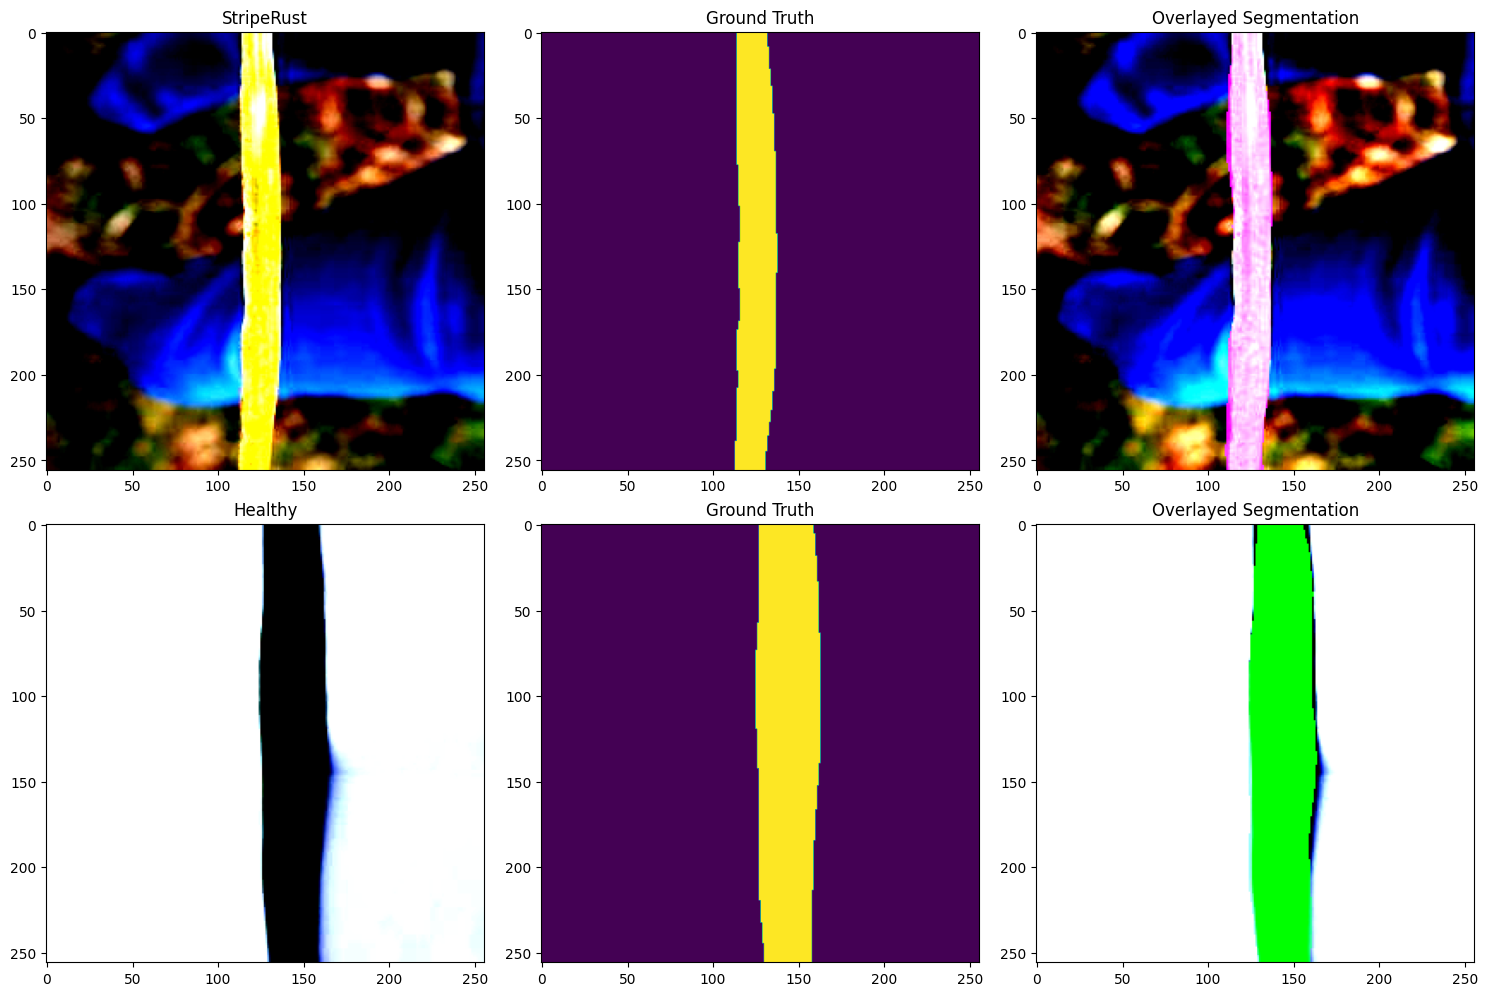

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

color_mapping = {
    1: (0, 128, 0),      # healthy_leaf: dark red
    2: (0, 0, 139),      # septoria: dark blue
    3: (139, 0, 139),    # stripe: dark pink

}


def overlay_segmentation(image, seg, alpha=0.6, beta=0.8):
    seg_rgb = np.zeros_like(image)
    for class_idx, color in color_mapping.items():
        if class_idx != 0:  # Ignore black pixels
            seg_rgb[seg == class_idx] = color

    # Set black pixels in the segmentation mask to transparent
    mask = (seg == 0)
    seg_rgb[mask] = image[mask]

    # Add contrast to the overlayed image
    img_overlayed = cv2.addWeighted(image, alpha, seg_rgb, beta, 0)

    return img_overlayed

def plot_images_rgb(xb, yb, logits,labels):
    num_images = xb.shape[0]
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5*num_images))

    for i in range(num_images):
        image = xb[i].permute(1, 2, 0).cpu().numpy()  # Convert to NumPy array
        image_rgb = image if image.shape[2] == 3 else image[:, :, 0]  # Handle grayscale images
        ground_truth = yb[i].cpu().numpy()
        prediction = torch.argmax(logits[i], dim=0).cpu().numpy()

        img_overlayed = overlay_segmentation(image_rgb, prediction)

        axs[i, 0].imshow(image_rgb)
        axs[i, 1].imshow(ground_truth)
        axs[i, 2].imshow(img_overlayed)

        axs[i, 0].set_title(labels[i])
        axs[i, 1].set_title('Ground Truth')
        axs[i, 2].set_title('Overlayed Segmentation')

    plt.tight_layout()
    plt.show()


# feeding model test_loader getting back images groud_truth prediction
xb, yb, upscaled,labels = get_predictions(test_loader, segformer_model)
plot_images_rgb(xb, yb, upscaled,labels)

In [ ]:
print(xb.shape, yb.shape, upscaled.shape)

torch.Size([2, 3, 256, 256]) torch.Size([2, 256, 256]) torch.Size([2, 4, 256, 256])


# EXPORTING A MODEL FROM PYTORCH TO ONNX AND RUNNING IT USING ONNX RUNTIME

In [ ]:
! pip install onnx
! pip install transformers[onnx] torch

In [ ]:
import transformers
import transformers.convert_graph_to_onnx as onnx_convert
from pathlib import Path
import onnx

segformer_model = segformer_model.to("cuda")
xb = xb.to("cuda")
segformer_model.eval()

# Export the model
torch.onnx.export(segformer_model,               # model being run
                  xb,                         # model input (or a tuple for multiple inputs)
                  "segformer_model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  )

segformer_onnx_model = onnx.load("segformer_model.onnx")
onnx.checker.check_model(segformer_onnx_model)

You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
# !pip install onnx onnxruntime
import onnxruntime
ort_session = onnxruntime.InferenceSession("segformer_model.onnx")
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [81]:
xb, yb, upscaled,labels = get_predictions(test_loader, segformer_model)
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(xb)}
ort_outs = ort_session.run(None, ort_inputs)
tensor_ort_outs = torch.from_numpy(ort_outs[0])
print((tensor_ort_outs).shape, type(tensor_ort_outs) )
# #up scalling logits
ort_upscaled = upscale_logits((tensor_ort_outs))
print((ort_upscaled).shape, type(ort_upscaled) )
print((upscaled).shape, type(upscaled) )
# # compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(upscaled), ort_upscaled, rtol=1e-03, atol=1e-05)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")


torch.Size([2, 4, 64, 64]) <class 'torch.Tensor'>
torch.Size([2, 4, 256, 256]) <class 'torch.Tensor'>
torch.Size([2, 4, 256, 256]) <class 'torch.Tensor'>
Exported model has been tested with ONNXRuntime, and the result looks good!


torch.Size([2, 3, 256, 256]) torch.Size([2, 256, 256]) torch.Size([2, 4, 256, 256]) torch.Size([2, 4, 256, 256])


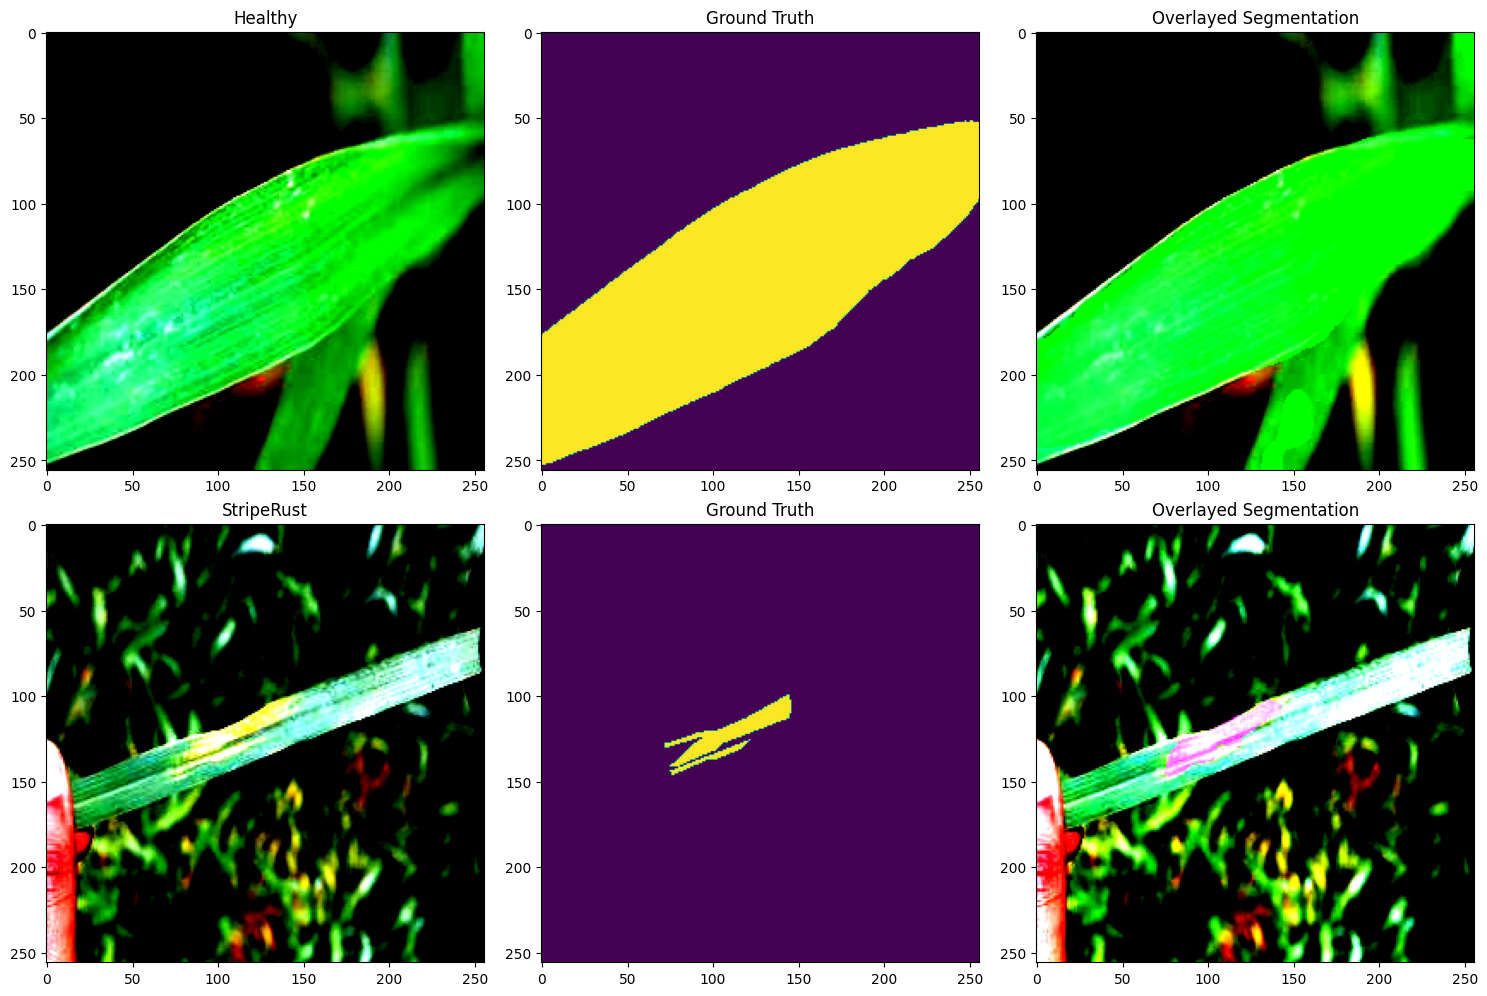

In [82]:
print(xb.shape, yb.shape, upscaled.shape,ort_upscaled.shape)
plot_images_rgb(xb, yb, ort_upscaled,labels)